# Amortized probabilistic models for chemical microscopy — part 2

A couple of tricks to improve the performance of this model.

In [36]:
import jax
import jax.numpy as jnp
import jax.nn as jnn
import flax.linen as nn
import matplotlib.pyplot as plt
import numpy as np
import numpyro.distributions as dist
import seaborn as sns
from numpyro import deterministic, plate, sample
from numpyro.handlers import seed, trace
from numpyro.infer import SVI, Trace_ELBO, Predictive
from numpyro.infer.autoguide import AutoNormal
from numpyro.optim import Adam
from PIL import Image
import pandas as pd

plt.rcParams['figure.dpi'] = 200

sns.set_theme(context='paper', style='ticks', font='Arial')

We'll use the same delightful microscope image as last time, part of the experiments that went into our [latest paper](https://doi.org/10.1039/D5DD00100E).

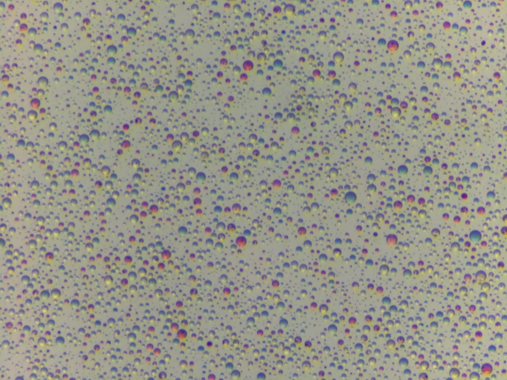

In [2]:
img = Image.open('data/example.jpg')
img = img.resize((img.width // 4, img.height // 4))
img

In [3]:
img = np.array(img) / 255.0

A little tweak to the model: if composition is all close to zeros you want the background value to be return relatively unchanged.

In [238]:
class DropletOpticsModel(nn.Module):
    hidden_dims: tuple = (32, 16, 8)
    
    @nn.compact
    def __call__(self, background, dx, dy, radius, composition):
        """
        Args:
            background: (batch, n_channels) - existing/background pixel values
            dx: (batch, 1) - normalized distance from droplet center in x-direction
            dy: (batch, 1) - normalized distance from droplet center in y-direction
            radius: (batch, 1) - droplet radius
            composition: (batch, n_composition_features) - droplet composition vector
        
        Returns:
            new_pixel_value: (batch, n_channels) - predicted new pixel values
        """
        # Concatenate all input features
        x = jnp.concatenate([background, dx, dy, radius, composition], axis=-1)

        for i, dim in enumerate(self.hidden_dims):
            x = nn.Dense(dim, name=f'hidden_{i}')(x)
            x = nn.LayerNorm(name=f'ln_{i}')(x)
            x = jnn.relu(x)
        
        # Output layer - predict change in pixel values
        droplet = jnn.sigmoid(nn.Dense(background.shape[-1], name='output')(x))

        mixing = composition.sum(axis=-1, keepdims=True)
        mixing = mixing / (mixing + 1)
        mixing *= radius / (radius + dx**2 + dy**2)

        new_pixel_value = background * (1 - mixing) + droplet * mixing

        return new_pixel_value

# Initialize model
droplet_model = DropletOpticsModel()

# Test with dummy data
key = jax.random.PRNGKey(42)
batch_size, n_channels, n_composition = 32, 3, 10

dummy_background = jax.random.uniform(key, (batch_size, n_channels))
dummy_dx = jax.random.uniform(key, (batch_size, 1), minval=-1.0, maxval=1.0)
dummy_dy = jax.random.uniform(key, (batch_size, 1), minval=-1.0, maxval=1.0)
dummy_radius = jax.random.uniform(key, (batch_size, 1)) * 0.1  # Small radii
dummy_composition = jax.random.uniform(key, (batch_size, n_composition))

droplet_params = droplet_model.init(key, dummy_background, dummy_dx, dummy_dy, dummy_radius, dummy_composition)
print(droplet_model.tabulate(key, dummy_background, dummy_dx, dummy_dy, dummy_radius, dummy_composition))


                           DropletOpticsModel Summary                           
┏━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┓
┃ path     ┃ module         ┃ inputs         ┃ outputs        ┃ params         ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━┩
│          │ DropletOptics… │ -              │ float32[32,3]  │                │
│          │                │ float32[32,3]  │                │                │
│          │                │ -              │                │                │
│          │                │ float32[32,1]  │                │                │
│          │                │ -              │                │                │
│          │                │ float32[32,1]  │                │                │
│          │                │ -              │                │                │
│          │                │ float32[32,1]  │                │                │
│          │               

In [219]:
def tree_to_dists(tree, path=''):
    if isinstance(tree, dict):
        return {k: tree_to_dists(v, path + '/' + k) for k, v in tree.items()}
    else:
        return sample(path, dist.Normal().expand(tree.shape))

def dists_to_tree(dists, result=None):
    result = result or {}
    for path, dist in dists.items():
        if '/' in path:
            root, rest = path.split('/', 1)
            result[root] = result.get(root, {})
            result[root].update(dists_to_tree({rest: dist}, result=result[root]))
        else:
            result[path] = dist
    return result

The main idea is to sample pixel batches from the image to use in SVI rather than the entire image, to reduce the memory needed for the distance calculation (the bottleneck).

In [242]:
def model_with_nn(img, n_droplets, types=10, subsample_size=10000):
    h, w, n_channels = img.shape
    img = jnp.array(img).reshape(h * w, n_channels)
    n_pixels = h * w

    droplet_model = DropletOpticsModel()
    droplet_params = droplet_model.init(
        key,
        jnp.zeros((h * w, n_channels)),
        jnp.zeros((h * w, 1)),
        jnp.zeros((h * w, 1)),
        jnp.zeros((h * w, 1)),
        jnp.zeros((h * w, types)),
    )
    droplet_params = tree_to_dists(droplet_params, path="nn_params")

    img_plate = plate("pixels", n_pixels, subsample_size=subsample_size, dim=-2)
    channel_plate = plate("channels", n_channels)

    # Create coordinate grids and background pixel values
    y_coords, x_coords = jnp.mgrid[:h, :w]
    with img_plate as ind:
        x_coords = x_coords.reshape(-1)[ind]
        y_coords = y_coords.reshape(-1)[ind]
    with channel_plate:
        bg = sample("bg", dist.Uniform(0, 1))
    bg_flat = jnp.broadcast_to(bg[None, :], (subsample_size, n_channels))

    # Sample droplet parameters
    with plate("droplets", n_droplets, subsample_size=None):
        x = sample("x", dist.Uniform(0, w))
        y = sample("y", dist.Uniform(0, h))
        r = sample("r", dist.LogNormal(0, 0.5))
        with plate("types", types):
            composition = sample("composition", dist.Uniform(0, 1)).T

    distance = ((x_coords[..., None] - x) / r) ** 2 + (
        (y_coords[..., None] - y) / r
    ) ** 2
    nearest = jnp.argmin(distance, axis=-1)

    # Calculate relative distances from droplet center
    dx = (x_coords - x[nearest]) / r[nearest]  # Normalized by radius
    dy = (y_coords - y[nearest]) / r[nearest]  # Normalized by radius

    dx_flat = dx[:, None]
    dy_flat = dy[:, None]
    r_flat = r[nearest].flatten()[:, None]

    # Repeat background and composition for all pixels
    comp_flat = composition[nearest, :].reshape(-1, types)

    # Apply neural network to get new pixel values
    prediction = droplet_model.apply(
        droplet_params, bg_flat, dx_flat, dy_flat, r_flat, comp_flat
    )

    prediction = deterministic("prediction", prediction)
    with img_plate as ind:
        with channel_plate:
            img = img[ind]
            diff = deterministic("diff", img - prediction)
            sample("obs", dist.Normal(scale=0.05), obs=diff)
    return droplet_params

In [243]:
tr = trace(seed(model_with_nn, 0)).get_trace(img, 1000, types=5)
droplet_params = seed(model_with_nn, 0)(img, 1000, types=5)
{k: v['value'].shape for k, v in tr.items() if 'value' in v}

{'nn_params/params/hidden_0/kernel': (11, 32),
 'nn_params/params/hidden_0/bias': (32,),
 'nn_params/params/ln_0/scale': (32,),
 'nn_params/params/ln_0/bias': (32,),
 'nn_params/params/hidden_1/kernel': (32, 16),
 'nn_params/params/hidden_1/bias': (16,),
 'nn_params/params/ln_1/scale': (16,),
 'nn_params/params/ln_1/bias': (16,),
 'nn_params/params/hidden_2/kernel': (16, 8),
 'nn_params/params/hidden_2/bias': (8,),
 'nn_params/params/ln_2/scale': (8,),
 'nn_params/params/ln_2/bias': (8,),
 'nn_params/params/output/kernel': (8, 3),
 'nn_params/params/output/bias': (3,),
 'pixels': (10000,),
 'channels': (3,),
 'bg': (3,),
 'droplets': (1000,),
 'x': (1000,),
 'y': (1000,),
 'r': (1000,),
 'types': (5,),
 'composition': (5, 1000),
 'prediction': (10000, 3),
 'diff': (10000, 3),
 'obs': (10000, 3)}

100%|██████████| 100000/100000 [03:19<00:00, 502.47it/s, init loss: 11922415.0000, avg. loss [95001-100000]: -807026.8750]


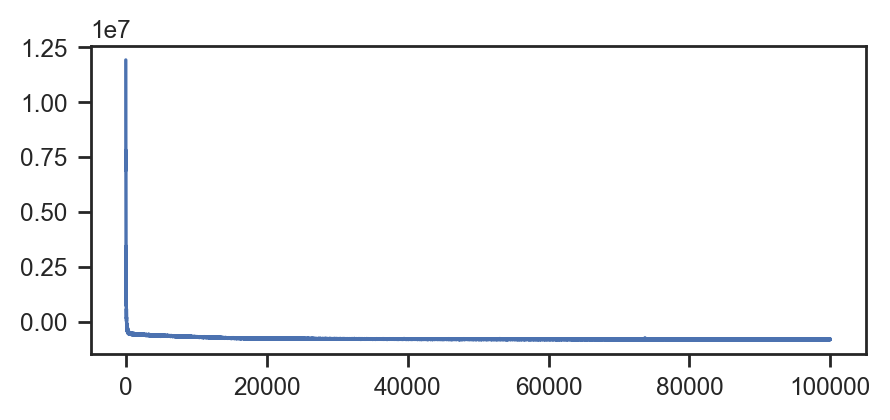

In [244]:
guide = AutoNormal(model_with_nn)
svi = SVI(model_with_nn, guide, Adam(lambda n: 0.01 * 0.1**(n / 50000)), Trace_ELBO())

svi_result = svi.run(jax.random.PRNGKey(0), 100000, img, 1600, types=3)
samples_svi = guide.sample_posterior(jax.random.PRNGKey(0), svi_result.params, subsample_size=(img.shape[0] * img.shape[1]), sample_shape=(10,))
fig, ax = plt.subplots(figsize=(5, 2))
ax.plot(svi_result.losses)

In [245]:
prior_predictive = Predictive(guide, params=svi_result.params, num_samples=10)(jax.random.PRNGKey(0), img, 1000, types=3, subsample_size=(img.shape[0] * img.shape[1]))
posterior_predictive = Predictive(model_with_nn, guide=guide, params=svi_result.params, num_samples=10)(jax.random.PRNGKey(0), img, 1000, types=3, subsample_size=(img.shape[0] * img.shape[1]))
predictive = {**prior_predictive, **posterior_predictive}

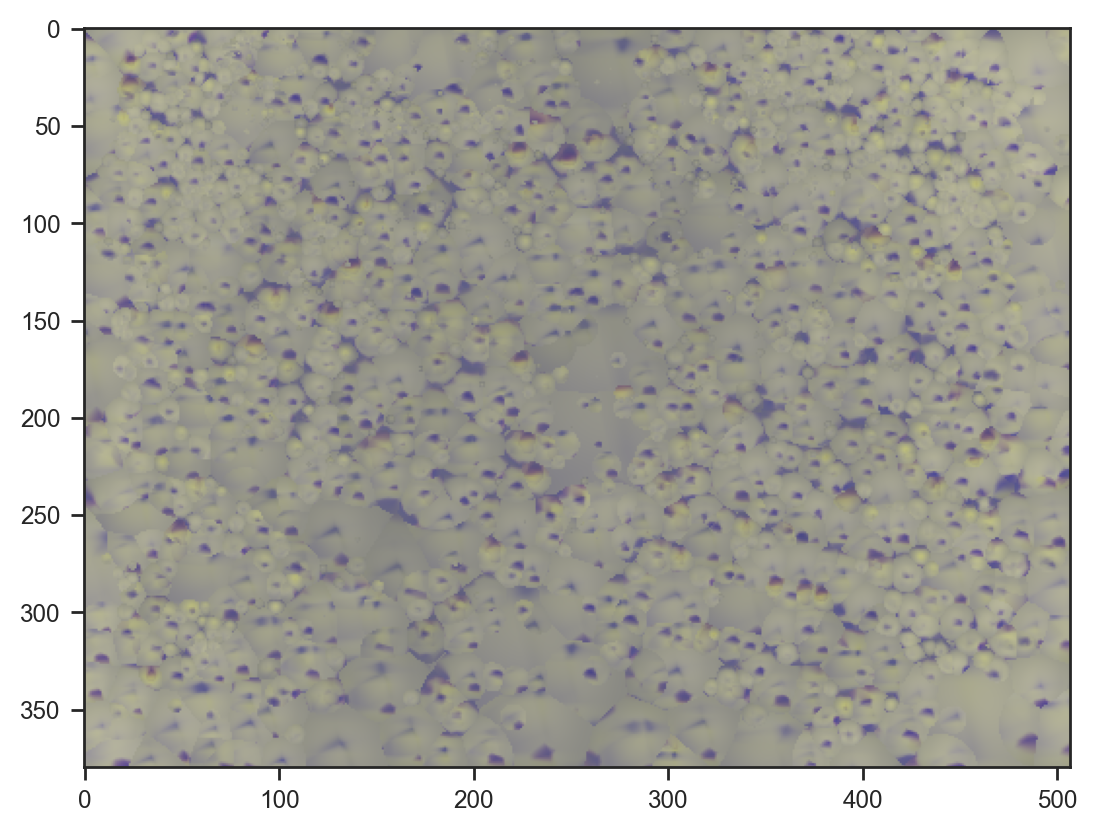

In [246]:
plt.imshow(predictive['prediction'][0].reshape(img.shape))

A slightly better construction, but also note that we were able to specify a larger # droplets than before, without filling up the GPU memory.

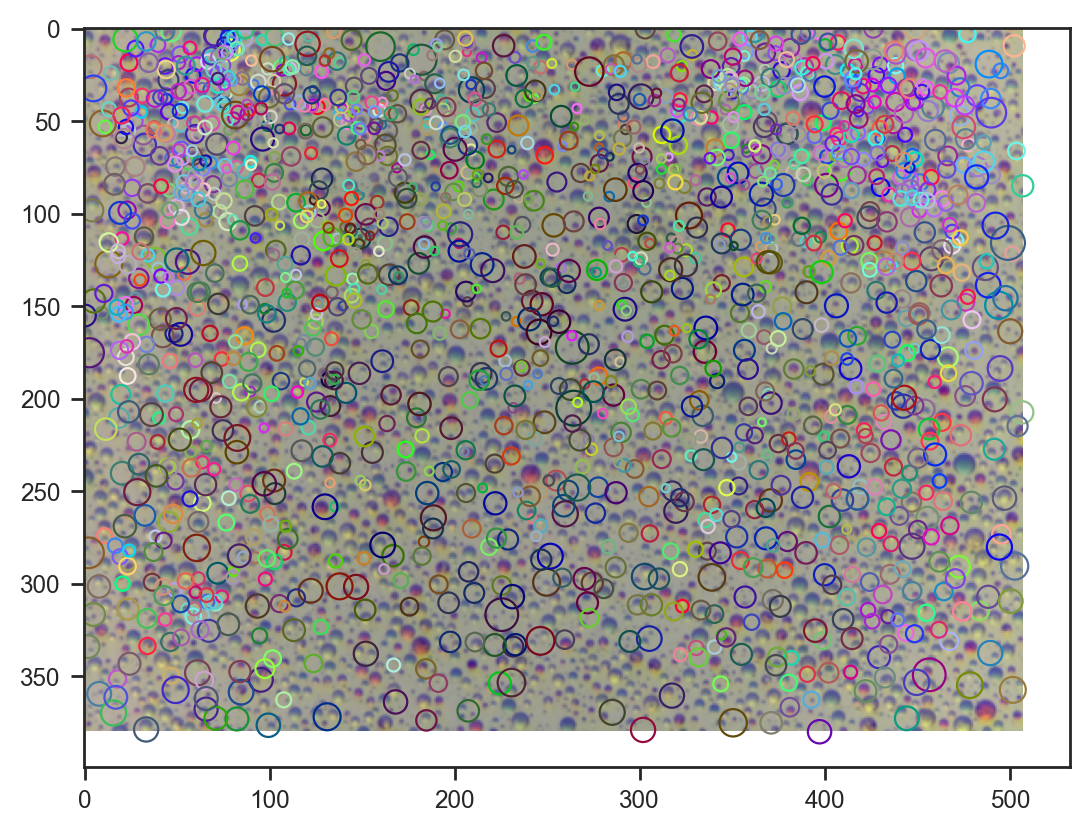

In [247]:
plt.imshow(img)
colors = np.zeros((predictive['x'].shape[1], 4))
comps = predictive['composition'][0]

plt.scatter(predictive['x'][0], predictive['y'][0], s=predictive['r'][0] * 10, facecolor='none', edgecolor=comps.T)

## Inspecting the droplet model

What is the droplet model really doing? Let's have a look:

In [248]:
from functools import partial
extracted_droplet_params = dists_to_tree({k.split('/', 1)[1]: v for k, v in guide.sample_posterior(jax.random.PRNGKey(0), svi_result.params).items() if 'nn_params/' in k})

droplet_eval = partial(droplet_model.apply, extracted_droplet_params)

In [249]:
samples_svi['bg']

Array([[0.45192575, 0.45382273, 0.46465632],
       [0.45182332, 0.453846  , 0.464624  ],
       [0.45188984, 0.45409188, 0.46445972],
       [0.45188618, 0.4537667 , 0.4642675 ],
       [0.45161793, 0.45386043, 0.46442813],
       [0.45185322, 0.45382538, 0.4646157 ],
       [0.45201865, 0.45338   , 0.4647558 ],
       [0.4518832 , 0.45344588, 0.46424782],
       [0.45144778, 0.453924  , 0.46461114],
       [0.45165873, 0.4536374 , 0.46440345]], dtype=float32)

<Axes: ylabel='Count'>

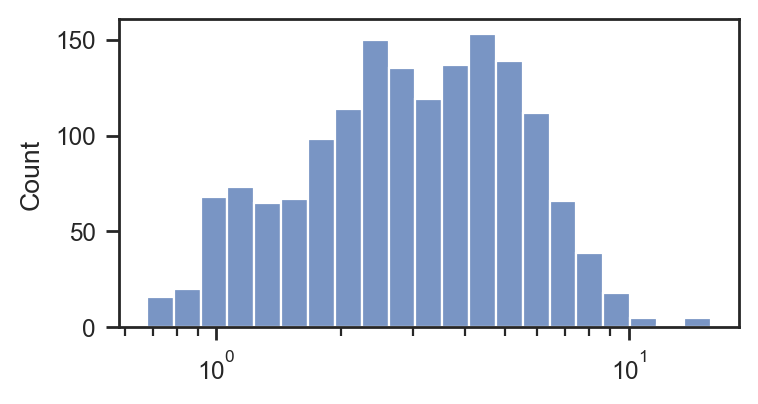

In [258]:
f, a = plt.subplots(figsize=(4, 2))
sns.histplot(samples_svi['r'][0], ax=a, log_scale=(True, False))

The first peak seems to correspond to the wandering, unassigned positions so a typical "good" radius would be 3.0.

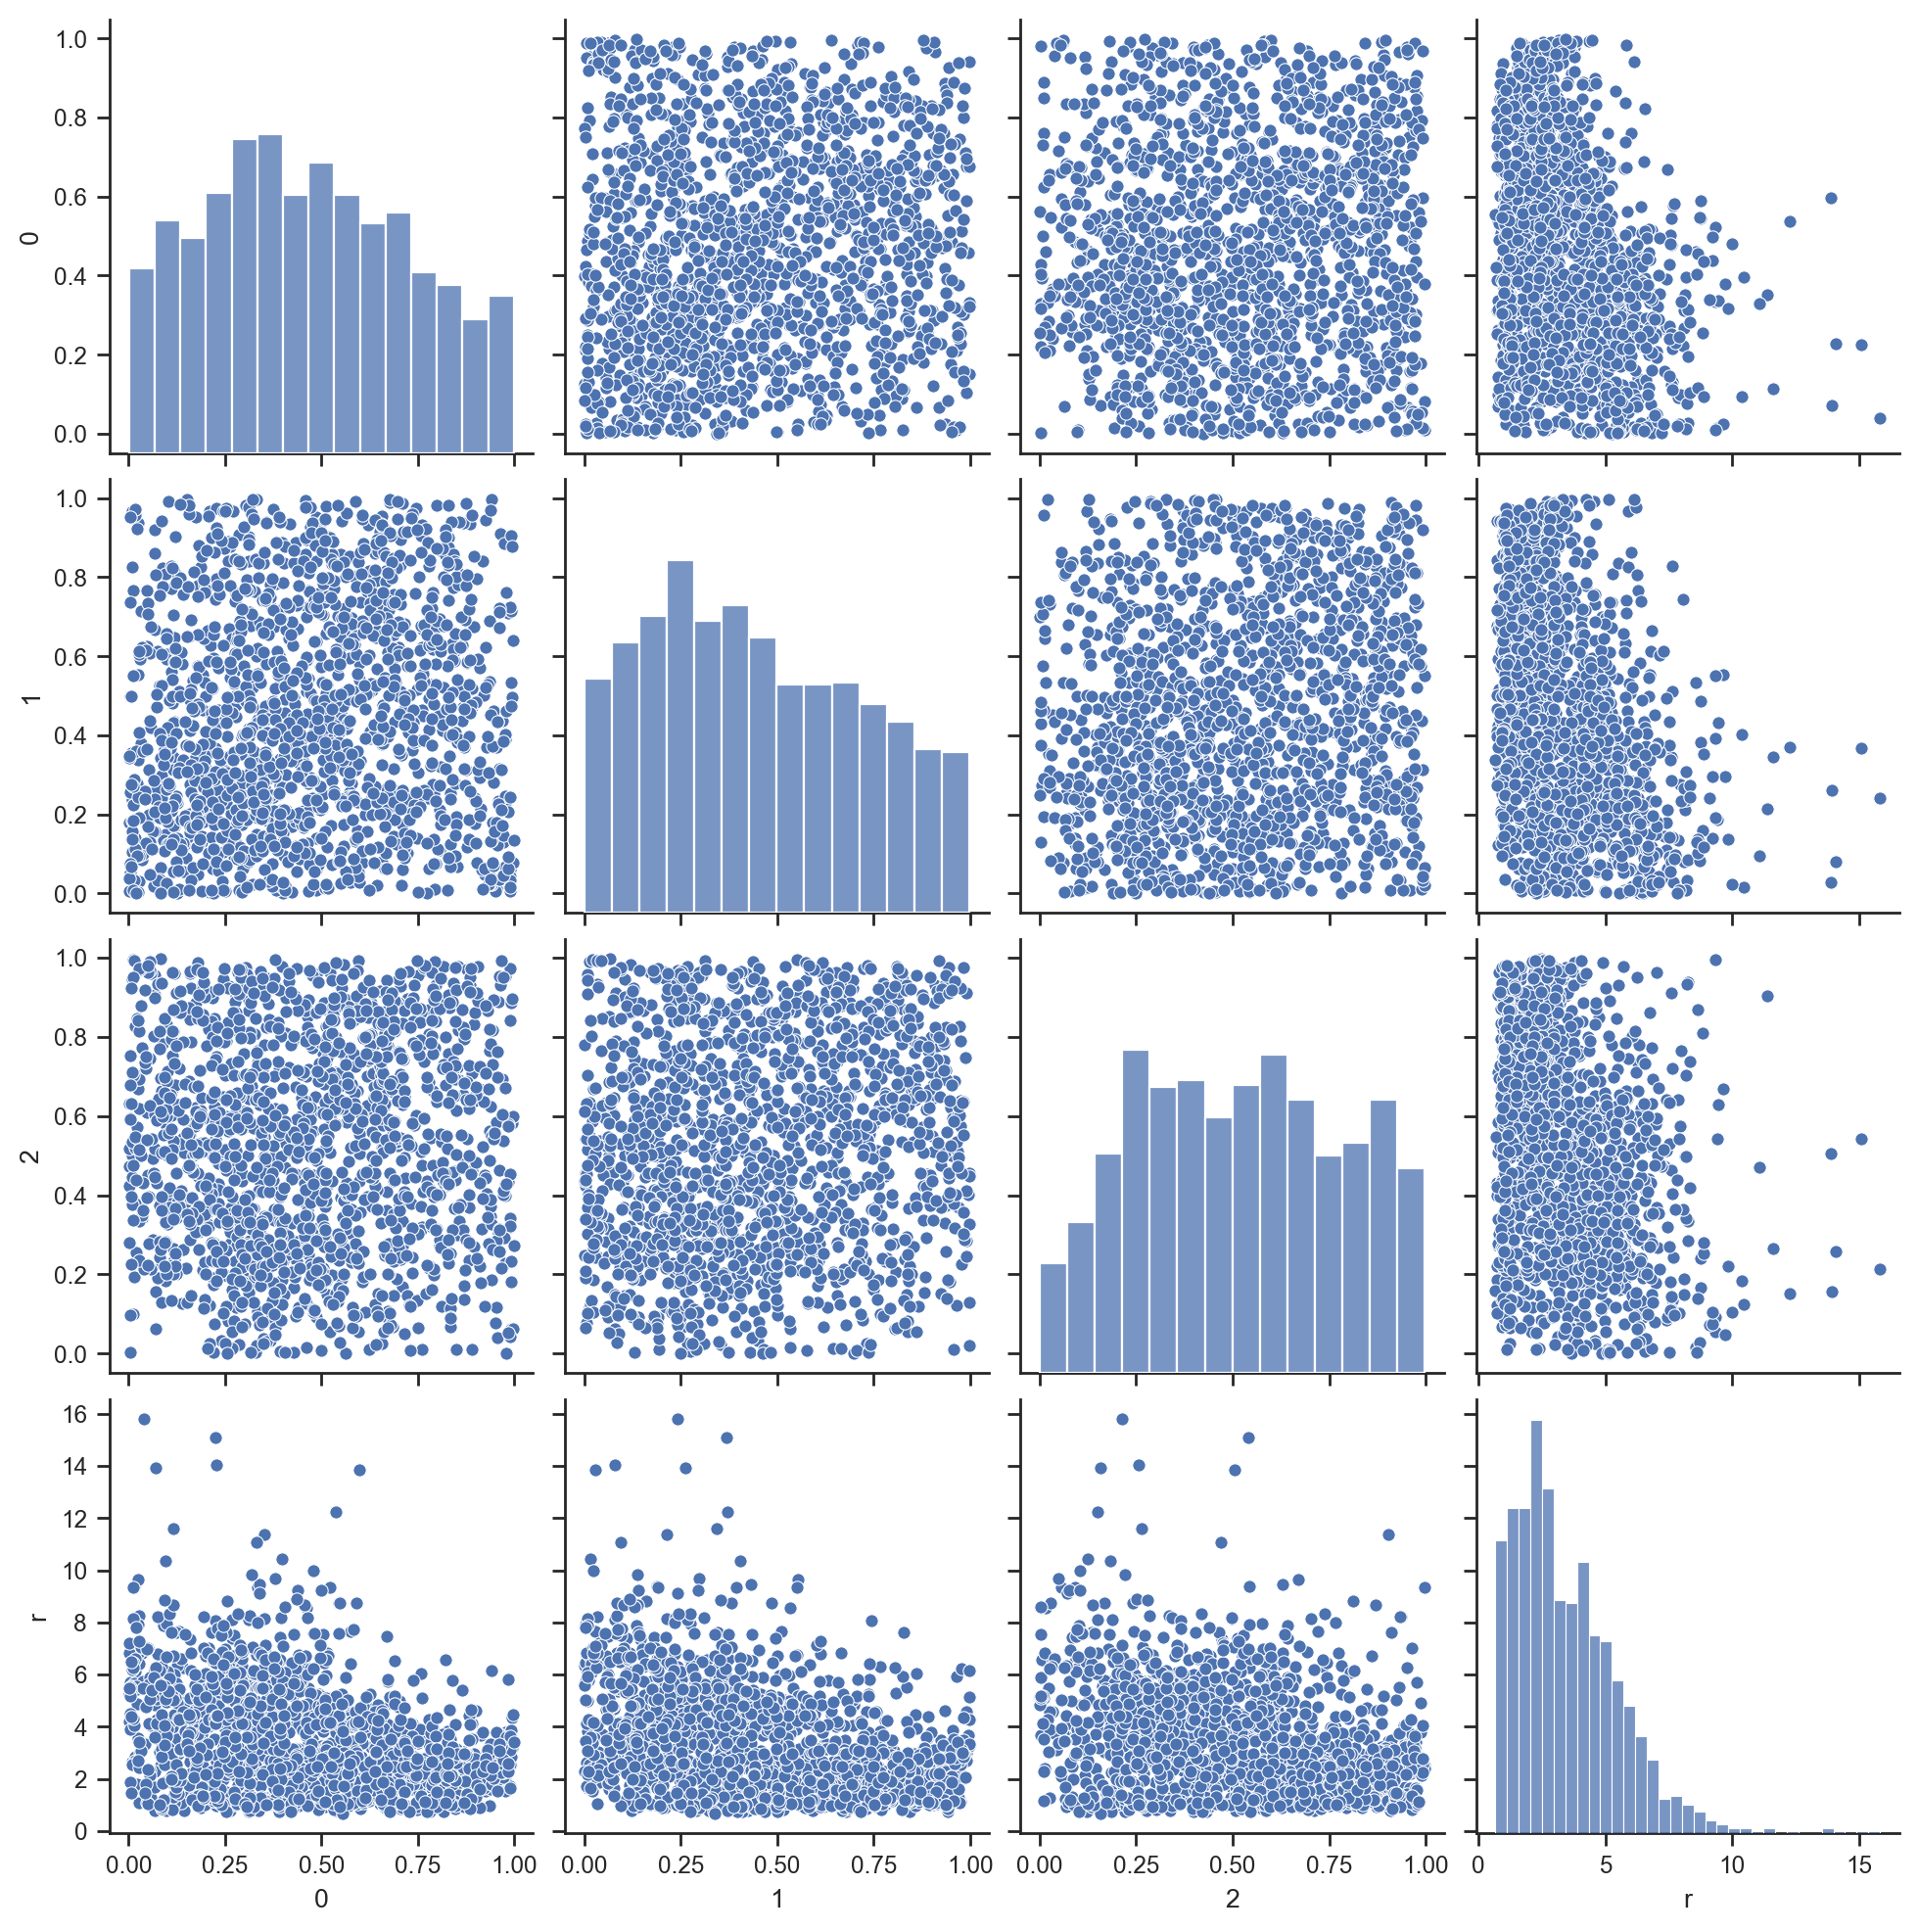

In [251]:
df = pd.concat([pd.DataFrame(samples_svi['composition'][0].T), pd.DataFrame(samples_svi['r'][0], columns=['r'])], axis=1)
df
sns.pairplot(df)

Composition seems to be all over the place and not strongly correlated with radius.

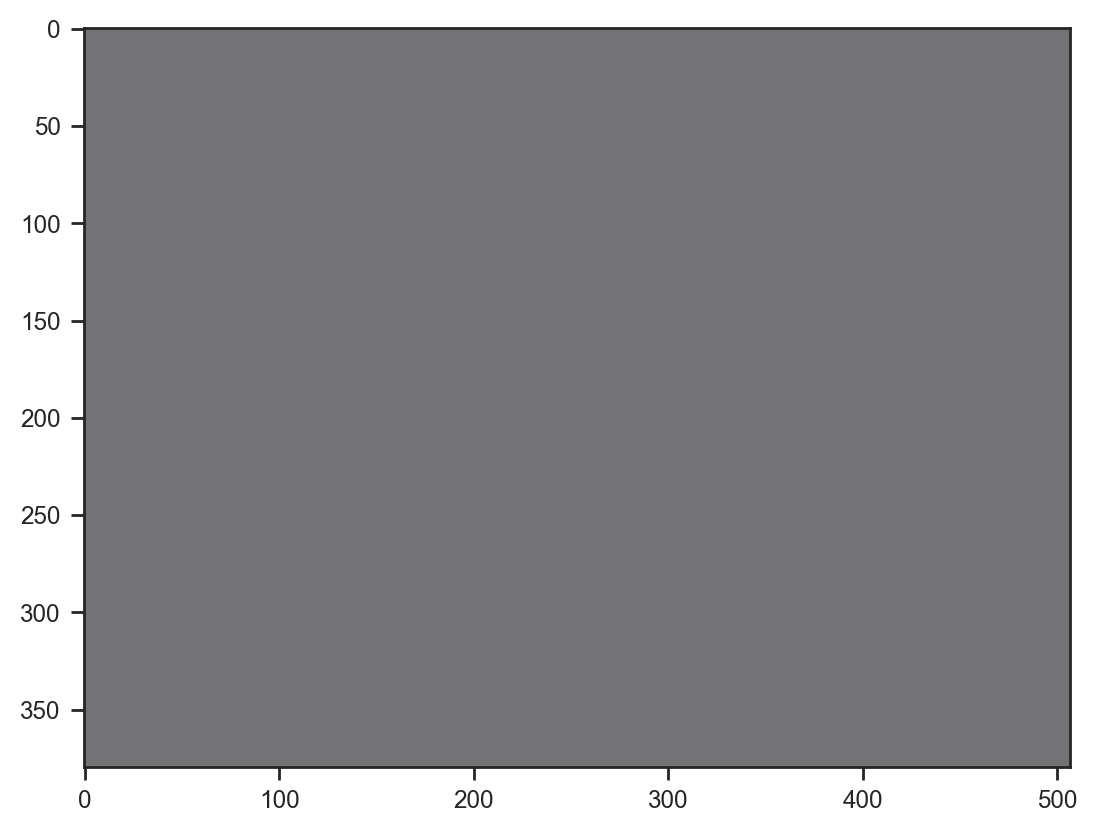

In [252]:
plt.imshow(np.broadcast_to(samples_svi['bg'][0][None, None, ...], img.shape))

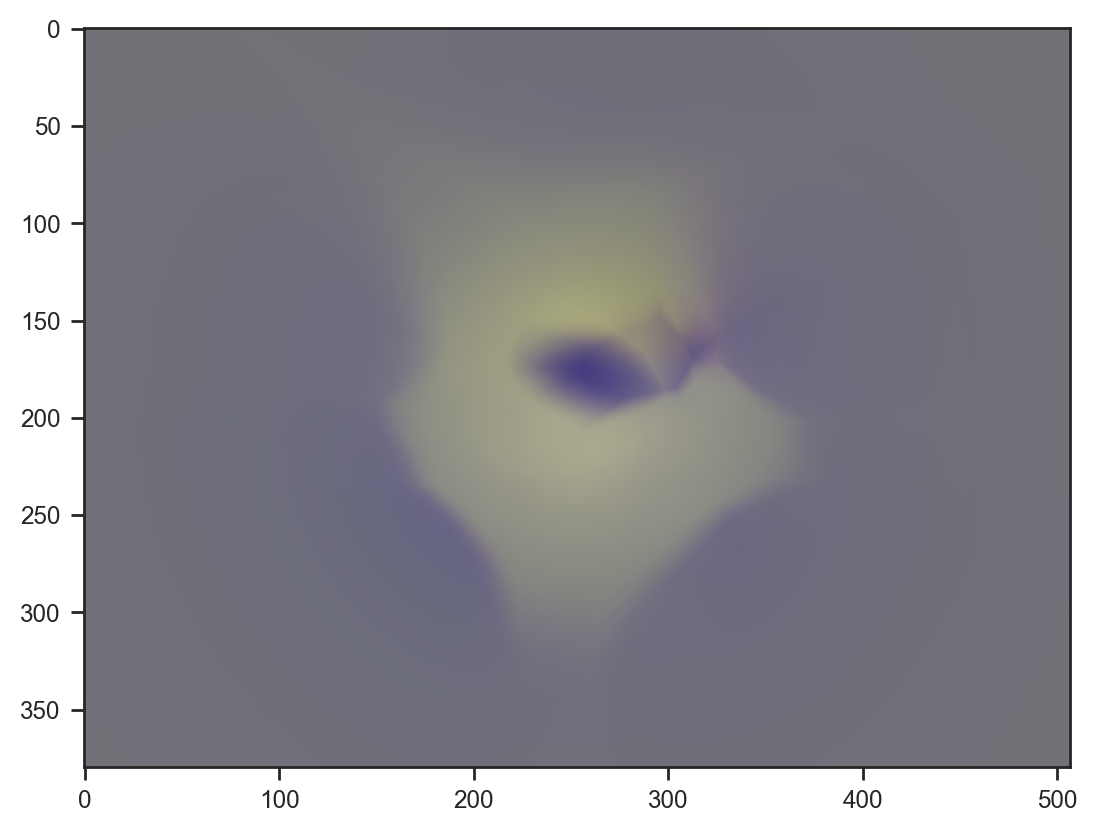

In [254]:
MAGNIFICATION = 10

y, x = jnp.mgrid[:img.shape[0], :img.shape[1]]
x = x.reshape((-1, 1)) - img.shape[1] // 2
y = y.reshape((-1, 1)) - img.shape[0] // 2
bg = np.broadcast_to(samples_svi['bg'][0][None, ...], (x.shape[0], img.shape[2]))
r = np.full((x.shape[0], 1), 3.0)
comp = np.full((x.shape[0], 3), np.array([1.0, 1.0, 0.0]))
predicted_img = droplet_eval(bg, x/r/MAGNIFICATION, y/r/MAGNIFICATION, r, comp).reshape(img.shape)
plt.imshow(predicted_img)

And there we have it, a nice little droplet. This method is quite neat as the droplets can be arbitrarily magnified.